# U-Net 구현의 목적
- **input_data 로 label에 최대한 가깝게 img segmentation 하는 모델 만들기**
- U-Net은 Classification이 아니다.
- U-Net과 ResNet의 기능(목적)은 다르다.
  - ResNet을 모델링 할 때와 같이 하면 안된다.

In [252]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from PIL import Image
import cv2

import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import adapted_rand_error

In [253]:
!pip install kagglehub

In [254]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hamzamohiuddin/isbi-2012-challenge")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'isbi-2012-challenge' dataset.
Path to dataset files: /kaggle/input/isbi-2012-challenge


In [255]:
import os

# 다운로드된 경로의 파일 목록 출력
files = os.listdir(path)
print("파일 목록:", files)

파일 목록: ['unmodified-data']


In [256]:
source_dir = path
print(source_dir)
# 출력 위치로 보아, 현재 파일은 /root/.cache/kagglehub/datasets/... 에 저장 됨.

/kaggle/input/isbi-2012-challenge


## `shutil` 이란?
- Shell Utilities 의 약자이다.
- 쉽게 말해, '파일 탐색기'에서 마우스로 하는 일(복사, 붙여넣기, 이동, 삭제 등)을 코드로 할 수 있게 해주는 라이브러리이다. <br></br>
## `copytree` 분석 - 폴더 통째 복사
`shutil.copytree(source_dir, destination_dir)`
- 기능 : 폴더를 통째로 복사한다. (폴더 안에 있는 파일 + 하위 폴더까지)
- **주의할 점⭐️**
  - `destination_dir`은 **존재하지 않는 이름**이어야 한다.
  - `shutil`이 복사를 시작하면서 목표 폴더를 **새로 만들기 때문**이다.
  - 만약 이미 있는 폴더 이름을 적으면 에러 발생

## `shutil.copy` - 파일 하나만 복사
`shutil.copy('/content/cat.jpg', '/content/dataset/cat_copy.jpg')`
- 데이터셋에서 특정 이미지 하나만 골라내고 싶을 때 사용한다.

## `shutil.move` - 파일/폴더를 옮길 때
`shutil.move('/content/download_data', '/content/my_project/data')`
- 다운로드 폴더에 있는 걸 내 작업 폴더로 옮길 때 사용한다.

## `shutil.rmtree` - 폴더를 통째로 삭제할 때 (🚨주의 필요)
파이썬 기본 명령어 `os.remove`는 폴더 안에 파일이 있으면 삭제를 못한다. 하지만 `shutil`은 강제로 싹 지워버린다.
`shutil.rmtree('/content/temp_folder')`
- 휴지통 없이 바로 삭제되니 유의하자.


In [257]:
destination_dir = '/content/my_dataset'

import shutil
shutil.copytree(source_dir, destination_dir)

FileExistsError: [Errno 17] File exists: '/content/my_dataset'

In [258]:
test_img_path = '/content/my_dataset/unmodified-data/test/imgs'
train_img_path = '/content/my_dataset/unmodified-data/train/imgs'

num_test_img = len(os.listdir(test_img_path))
num_train_img = len(os.listdir(train_img_path))

print(f"Test 이미지 개수: {num_test_img}")
print(f"Train 이미지 개수: {num_train_img}")

lets_find_listdir = os.listdir(test_img_path)
print(f"UnSorted listdir :  {lets_find_listdir}")
print(f"Sorted listdir : {sorted(lets_find_listdir)}")

Test 이미지 개수: 30
Train 이미지 개수: 30
UnSorted listdir :  ['frame_0001.png', 'frame_0002.png', 'frame_0005.png', 'frame_0027.png', 'frame_0014.png', 'frame_0006.png', 'frame_0030.png', 'frame_0011.png', 'frame_0015.png', 'frame_0018.png', 'frame_0023.png', 'frame_0010.png', 'frame_0021.png', 'frame_0024.png', 'frame_0017.png', 'frame_0013.png', 'frame_0019.png', 'frame_0008.png', 'frame_0003.png', 'frame_0020.png', 'frame_0022.png', 'frame_0016.png', 'frame_0029.png', 'frame_0004.png', 'frame_0007.png', 'frame_0026.png', 'frame_0012.png', 'frame_0028.png', 'frame_0009.png', 'frame_0025.png']
Sorted listdir : ['frame_0001.png', 'frame_0002.png', 'frame_0003.png', 'frame_0004.png', 'frame_0005.png', 'frame_0006.png', 'frame_0007.png', 'frame_0008.png', 'frame_0009.png', 'frame_0010.png', 'frame_0011.png', 'frame_0012.png', 'frame_0013.png', 'frame_0014.png', 'frame_0015.png', 'frame_0016.png', 'frame_0017.png', 'frame_0018.png', 'frame_0019.png', 'frame_0020.png', 'frame_0021.png', 'frame_002

# Transform

# 주의할 점
transform에서 crop, RandomFlip 등은 사용하면 안됨
- 이미지 따로, 마스크 따로 랜덤하게 돌아가서 서로 다른 그림이 되어버림
- 이 경우에는 CustomDataset 내부에서 전처리를 진행해줘도 좋음
  - transform 없애고 ~
  

## Transform with Albumentation

In [259]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(572, 572),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    #A.RandomCrop(height=224, width=224, p=0.5),

    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(572, 572),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/tmp/ipython-input-454220329.py:6: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.5),


## CustomDataset 구현 with `Albumentations`

In [260]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode = 'train', transform=None):
        self.data_dir = data_dir
        self.mode = mode

        self.img_folder = os.path.join(data_dir, mode, 'imgs')
        self.mask_folder = os.path.join(data_dir, mode, 'labels')

        self.img_files = sorted(os.listdir(self.img_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_folder, self.img_files[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Fix: Read mask directly as grayscale to ensure 1 channel
        mask = cv2.imread(os.path.join(self.mask_folder, self.mask_files[idx]), cv2.IMREAD_GRAYSCALE)

        # mask = (mask==0).astype(np.uint8)
        mask = mask / 255.0
        mask = mask.astype(np.uint8)


        # Albumentation
        # Albumentation은 PIL 보다 opencv와 더 잘 어울림 (Numpy 배열 사용 등의 이유..)
        if self.transform: # 왜 if문 사용? -> 만약 CustomDataset(..., transform=None)이라고 했을 때 에러 발생함 -> 에러 방지해줌
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [261]:
train_dataset = CustomDataset(data_dir = '/content/my_dataset/unmodified-data/', mode='train', transform=train_transform)
test_dataset = CustomDataset(data_dir = '/content/my_dataset/unmodified-data/', mode='test', transform=test_transform)

image, mask = train_dataset[0]

print(f"이미지 크기: {image.shape}")
print(f"마스크 크기: {mask.shape}")

이미지 크기: torch.Size([3, 572, 572])
마스크 크기: torch.Size([572, 572])


In [262]:
train_size = int(0.8* len(train_dataset))
print("train_size : ")
print(train_size)

val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_size : 
24


In [263]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [264]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [265]:
def center_crop(original, target):
    original_height, original_width = original.shape[2], original.shape[3]
    target_size = target.shape[2]

    to_crop = (original_height - target_size) // 2

    # Fix: Corrected typo in width slicing
    return original[:, :, to_crop:to_crop+target_size, to_crop:to_crop+target_size]

In [266]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.conv = Block(in_channels, out_channels, stride=1)

    def forward(self, x1, x2):
      # x1 : Decoder 에서 올라온거
      # x2 : Encoder에서 온 거 (Crop 필요)

      x1 = self.up(x1)
      x2 = center_crop(x2, x1)

      x = torch.cat([x2, x1], dim=1)
      x = self.conv(x)
      return x

In [267]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        # Contracting Path
        # Stem : Raw data를 Feture로 변환하는 신경망의 초입부
        self.stem = Block(n_channels, 64, stride=1) # 3채널 이미지 -> 64채널

        # Body : 변환된 feature로 핵심 정보 추출하는 단계
        self.pool = nn.MaxPool2d(2)
        self.body_down1 = Block(64, 128, stride=1)
        self.body_down2 = Block(128, 256, stride=1)
        self.body_down3 = Block(256, 512, stride=1)

        self.body_bottom = Block(512, 1024, stride=1)

        self.body_up1 = UpBlock(1024, 512)
        self.body_up2 = UpBlock(512, 256)
        self.body_up3 = UpBlock(256, 128)
        self.body_up4 = UpBlock(128, 64)

        # Head : 최종 Segmentation (다른 모델에서는 Classification)을 내리는 단계
        self.head = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Stem
        x1 = self.stem(x)

        # Body - Encoder (Contracting Path)
        x2 = self.body_down1(self.pool(x1))
        x3 = self.body_down2(self.pool(x2))
        x4 = self.body_down3(self.pool(x3))

        # Body - Bottom
        x5 = self.body_bottom(self.pool(x4))

        # Body - Decoder (Expansive Path)
        # 구조적 대칭성으로 인하여 Encoder에서 내려갔던 순서의 정반대로 꺼내서 연산해야 한다.
        x = self.body_up1(x5, x4) # x5 + x4
        x = self.body_up2(x, x3) # x(방금 연산 결과) + x3
        x = self.body_up3(x, x2)
        x = self.body_up4(x, x1)

        # Head
        x = self.head(x)
        return x



# Loss Function & Optimizer

In [268]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=2).to(device)

In [269]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.99)

# Training model

In [270]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()

    running_loss=0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        optimizer.zero_grad()
        outputs=model(inputs)

        if targets.shape != outputs.shape[-2:]:  # outputs: (B, C, H, W), targets : (B, H, W)
            h_out, w_out = outputs.shape[2], outputs.shape[3]
            h_target, w_target = targets.shape[1], targets.shape[2]

            crop_h = (h_target - h_out) // 2
            crop_w = (w_target - w_out) // 2

            targets = targets[:, crop_h:crop_h+h_out, crop_w:crop_w+w_out]

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total += targets.numel()
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch + 1} : 평균 Loss = {running_loss / len(train_loader)}")

    return epoch_loss, epoch_acc

In [271]:
def val(model, val_loader, criterion):
    model.eval()

    test_loss=0.0
    correct=0
    total=0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            # Removed the following lines as they convert targets to float type
            # targets = targets / 255.0
            # targets = 1.0 - targets

            outputs = model(inputs)

            if targets.shape != outputs.shape[-2:]:  # outputs: (B, C, H, W), targets : (B, H, W)
                h_out, w_out = outputs.shape[2], outputs.shape[3]
                h_target, w_target = targets.shape[1], targets.shape[2]

            crop_h = (h_target - h_out) // 2
            crop_w = (w_target - w_out) // 2

            targets = targets[:, crop_h:crop_h+h_out, crop_w:crop_w+w_out]

            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.numel()
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy : {accuracy:.2f}%")
    return accuracy

# Pixel Error, Rand Error & Warping Error
### Pixel Error
- Original Label과 Segmented 된 것 사이의 불일치하는 픽셀들의 비율
- 경계의 약간의 변화에도 민감하게 반응한다.


### Rand Error
-


### Warping Error
- 위상학적인(Topology) 불일치에 대한 Error를 측정


In [272]:
def calc_Metrics(pred_mask, true_mask):
    pixel_error = 1.0 - (pred_mask == true_mask).mean()

    error, precision, recall = adapted_rand_error(image_true=true_mask, image_test=pred_mask)
    rand_error = error

    return pixel_error, rand_error

def evaluate_metrics(model, data_loader, device):
    model.eval()
    total_pixel_error = 0.0
    total_rand_error = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks_np = masks.numpy().squeeze().astype(int) # 정답 마스크 : (Batch, H, W) 형태이어야 한다.

            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            preds_np = preds.cpu().numpy().squeeze().astype(int)

            if masks_np.shape[-2:] != preds_np.shape[-2:]:
                h_out, w_out = preds_np.shape[-2], preds_np.shape[-1]
                h_target, w_target = masks_np.shape[-2], masks_np.shape[-1]

                crop_h = (h_target - h_out) // 2
                crop_w = (w_target - w_out) // 2

                if masks_np.ndim == 3: # Batch, H, W
                    masks_np = masks_np[:, crop_h:crop_h+h_out, crop_w:crop_w+w_out]
                elif masks_np.ndim == 2: # H, W
                    masks_np = masks_np[crop_h:crop_h+h_out, crop_w:crop_w+w_out]

            if preds_np.ndim == 2: # Batch 단위 계산
                p_err, r_err = calc_Metrics(preds_np, masks_np)
                total_pixel_error += p_err
                total_rand_error += r_err
                num_batches += 1
            else:
                for i in range(preds_np.shape[0]):
                    p_err, r_err = evaluate_metrics(preds_np[i], masks_np[i])
                    total_pixel_error += p_err
                    total_rand_error += r_err
                    num_batches += 1

    avg_pixel_error = total_pixel_error / num_batches
    avg_rand_error = total_rand_error / num_batches

    print("[Evaluation Result]")
    print(f"Pixel Error : {avg_pixel_error:.4f}")
    print(f"Rand Error : {avg_rand_error:.4f}")

    return avg_pixel_error, avg_rand_error



In [273]:
epochs = 50
best_acc = 0.0
best_model_wts = None

train_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    #loss = train(model, train_loader ,optimizer, criterion, epoch)
    loss, acc = train(model, train_loader, optimizer, criterion, epoch)
    train_loss.append(loss)
    train_accuracy.append(acc)
    #train_loss.append(loss)

    val_acc = val(model, val_loader, criterion)
    val_accuracy.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

model.load_state_dict(best_model_wts)

Epoch 1 : 평균 Loss = 0.4271635326246421
Validation Accuracy : 78.57%
Epoch 2 : 평균 Loss = 0.34730734055240947
Validation Accuracy : 83.34%
Epoch 3 : 평균 Loss = 0.3049303765098254
Validation Accuracy : 79.89%
Epoch 4 : 평균 Loss = 0.2906593047082424
Validation Accuracy : 81.77%
Epoch 5 : 평균 Loss = 0.27669310569763184
Validation Accuracy : 87.73%
Epoch 6 : 평균 Loss = 0.2542331013828516
Validation Accuracy : 78.15%
Epoch 7 : 평균 Loss = 0.24391785636544228
Validation Accuracy : 87.47%
Epoch 8 : 평균 Loss = 0.22494935306409994
Validation Accuracy : 79.03%
Epoch 9 : 평균 Loss = 0.23734325480957827
Validation Accuracy : 87.38%
Epoch 10 : 평균 Loss = 0.23650022968649864
Validation Accuracy : 87.19%
Epoch 11 : 평균 Loss = 0.22155243841310343
Validation Accuracy : 85.74%
Epoch 12 : 평균 Loss = 0.21986445039510727
Validation Accuracy : 84.03%
Epoch 13 : 평균 Loss = 0.217823908974727
Validation Accuracy : 87.89%
Epoch 14 : 평균 Loss = 0.21438891751070818
Validation Accuracy : 86.66%
Epoch 15 : 평균 Loss = 0.213711806883

<All keys matched successfully>

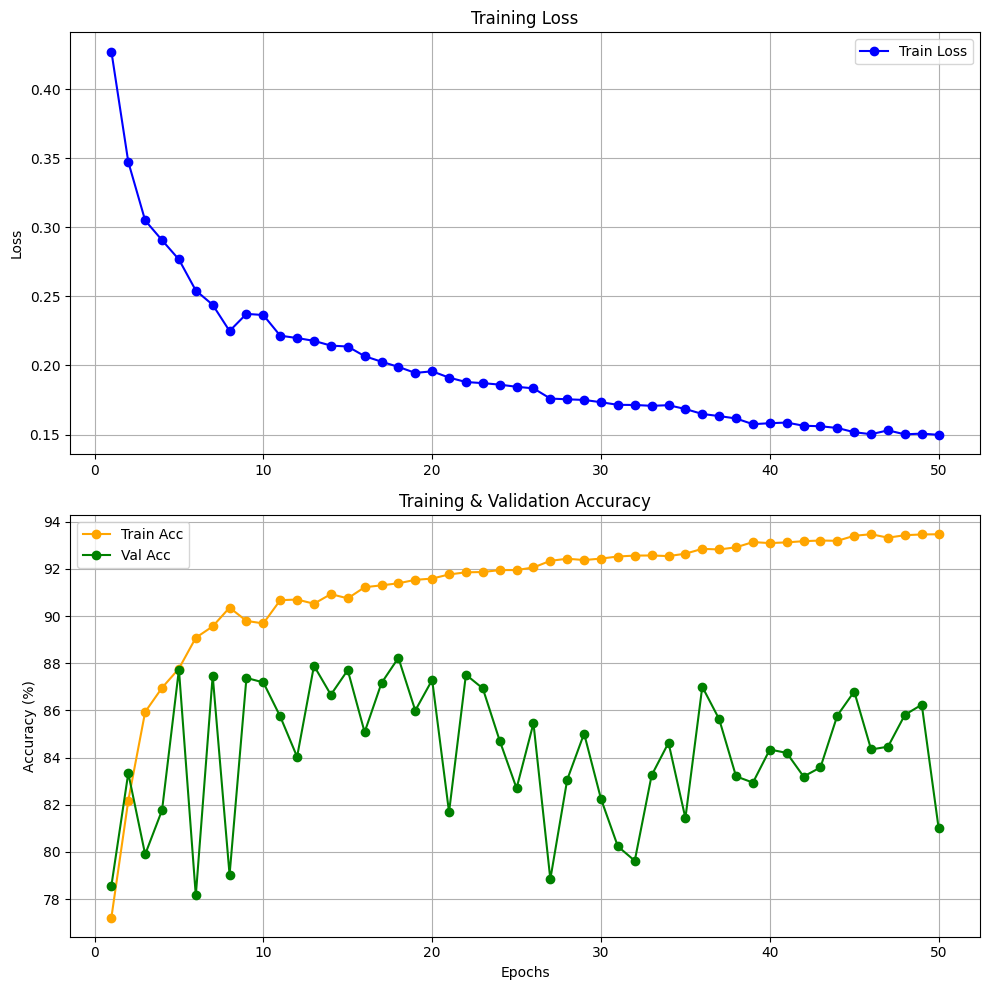

In [274]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs+1), train_loss, label='Train Loss', color='blue', marker='o')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Train Acc', color='orange', marker='o')
plt.plot(range(1, epochs+1), val_accuracy, label = 'Val Acc', color='green', marker='o')
plt.title("Training & Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [275]:
def test(model, test_loader):
    model.eval()

    all_ids=[]
    all_preds=[]

    print('Start Testing')
    with torch.no_grad():
        for idx, (inputs, _) in enumerate(test_loader):
        # for images, img_ids in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs) # 출력 크기 : (1, 2, 388, 388)

            preds = torch.argmax(outputs, dim=1) # 예측값 추출하기 (채널차원 Max) : 배경인지, 세포인지의 확률 중 더 큰것 선택

            all_preds.append(preds.cpu())
            img_name = test_loader.dataset.img_files[idx]
            all_ids.append(img_name)

    return all_ids, all_preds

In [276]:
all_ids, all_preds = test(model, test_loader)

Start Testing


In [277]:
def visualize(all_ids, all_preds, data_dir, index=0):
    img_name = all_ids[index]
    pred_mask = all_preds[index].squeeze(0)

    img_path = os.path.join(data_dir, img_name)

    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title(f"Original Image :  {img_name}")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.show()

Start Testing


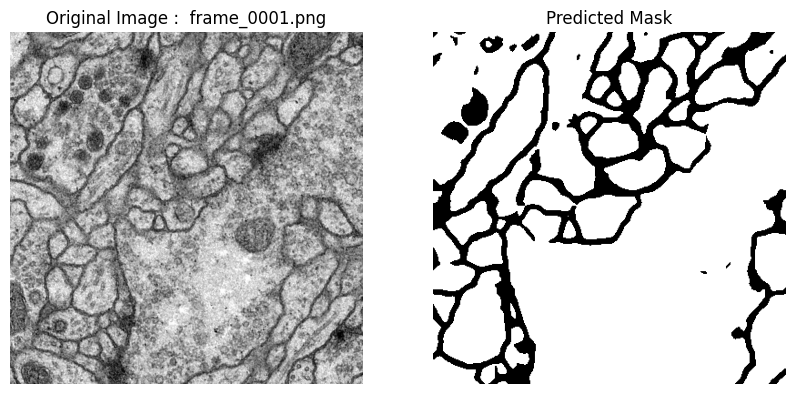

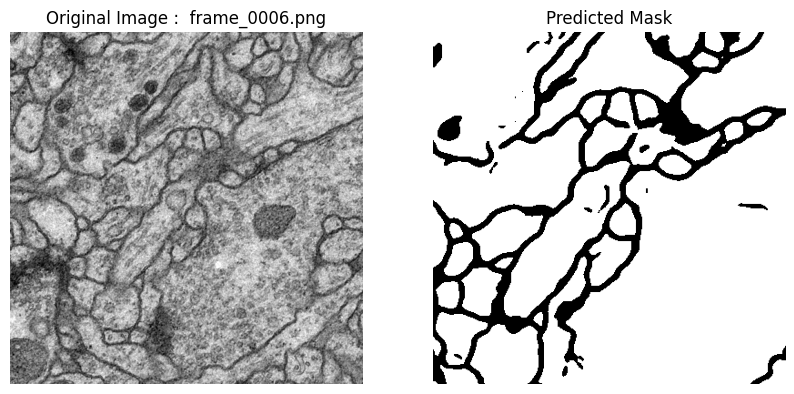

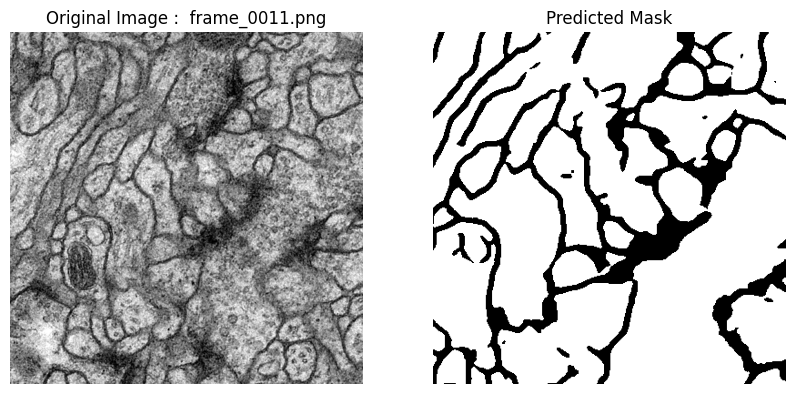

In [278]:
test_img_dir = '/content/my_dataset/unmodified-data/test/imgs'
all_ids, all_preds = test(model, test_loader)

visualize(all_ids, all_preds, test_img_dir, index = 0)

visualize(all_ids, all_preds, test_img_dir, index = 5)

visualize(all_ids, all_preds, test_img_dir, index = 10)

In [279]:
print("Test 데이터셋 평가 시작")
evaluate_metrics(model, test_loader, device)

Test 데이터셋 평가 시작
[Evaluation Result]
Pixel Error : 0.1068
Rand Error : 0.0307


(np.float64(0.10680686930952635), np.float64(0.030686320842776157))